# Summer Ar Lamp 2025 CMZ Analysis Part 2/2

Given the visibility signals, the goal of this code is to identify the fringe at which a path length difference of 0 is reached.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit
import uncertainties
import pandas as pd
from numba import njit

In [2]:
#load the spot parameters
#CSVs load in dataframe elements which are arrays or lists as strings, so we'd better just use saved data files from part 1/2.
#Elements which are just numbers are fine, though.

spot_df = pd.read_csv('f25A_Ar/spot_csv_ASI183_f25A_first8000FT.csv')

#### Put the visibility values and bin centers into arrays and show spot_df

In [3]:
#The independent variable array
displacements = np.load('f25A_Ar/displacements_f25A.npy')

#visibility data and uncertainties
vis_vals = []
vis_uncs = []

for i, spot in spot_df.iloc[::2].iterrows():
    name = f"f25A_Ar/ASI183_f25A_wavelength{1+i//2}_out{spot['output']}_vis"
    file_name = name + ".npy"
    ufile_name = name + "_unc.npy"
    vis_vals.append(np.load(file_name))
    vis_uncs.append(np.load(ufile_name))

spot_df #FIXME: don't trust array-valued entries; they're strings.

,Unnamed: 0,output,x_start,y_start,x_end,y_end,display_color,exp wl,x_center,y_center,hist_vals,unc_vals,vis_vals,vis_uncs,fft_vals,fft_vis_vals,vis_freq_max(inv um)
0,0,1,946,1151,980,1162,#000000,852.14411,963.0,1156.5,[473.7881 450.90033 420.95642 ... 97.1336...,[2.58164599 2.60249659 2.61285503 ... 2.456218...,"[-0.04070223288033933, -0.07693117940016997, -...","[0.003331045818256141, 0.003433185250409085, 0...",[2707815.8 +0.j 18700.17 -110973.4j...,[-485.11879217 +0.j -10.47154115+71.2...,0.01030
1,1,2,1210,2040,1230,2051,#000000,852.14411,1220.0,2045.5,[513.993 526.05896 575.09204 ... 54.608 ...,[1.98003209 1.99602377 2.00396833 ... 1.883833...,"[-0.04070223288033933, -0.07693117940016997, -...","[0.003331045818256141, 0.003433185250409085, 0...",[3061593.8 +0.j 35321.754-184162.22j...,[-485.11879217 +0.j -10.47154115+71.2...,0.01030
2,2,1,1180,1158,1212,1169,#2ca02c,842.00000,1196.0,1163.5,[1276.3888 1184.4944 982.5472 ... 336.772...,[2.5045645 2.52479255 2.53484171 ... 2.382881...,"[-0.29630570450124877, -0.3536105072471009, -0...","[0.0010868219933066708, 0.0010903988334020284,...",[8783731. +0.j 114191.984-466698.34j...,[-1541.16995966 +0.j 33.9384313 -1...,0.01045
3,3,2,1445,2041,1472,2062,#2ca02c,842.00000,1458.5,2051.5,[2351.291 2480.4612 2758.5461 ... 564.298...,[3.17872105 3.20439391 3.21714802 ... 3.024284...,"[-0.29630570450124877, -0.3536105072471009, -0...","[0.0010868219933066708, 0.0010903988334020284,...",[14822820. +0.j -27475.611-35042.84...,[-1541.16995966 +0.j 33.9384313 -1...,0.01045
4,4,1,1221,1160,1249,1169,#d62728,826.45215,1235.0,1164.5,[707.5738 660.6494 562.6872 ... 91.13278 ...,[2.11914737 2.13626261 2.14476535 ... 2.016189...,"[-0.4322310201762187, -0.47518782599909215, -0...","[0.0013543296996019701, 0.0013659464206222576,...",[4766157.5 +0.j 171705.53-444534.7j ...,[-2457.62846881 +0.j 96.94483962-3...,0.01045
5,5,2,1489,2044,1509,2063,#d62728,826.45215,1499.0,2053.5,[1784.897 1857.011 1991.068 ... 458.232...,[2.60227199 2.62328917 2.63373037 ... 2.475842...,"[-0.4322310201762187, -0.47518782599909215, -0...","[0.0013543296996019701, 0.0013659464206222576,...",[ 1.0179461e+07 +0.j -4.6196609e+04-1212...,[-2457.62846881 +0.j 96.94483962-3...,0.01045
6,6,1,1570,1170,1599,1182,#9467bd,811.00000,1584.5,1176.0,[1236.3162 1139.4207 970.4728 ... 482.707...,[2.49029336 2.51040615 2.52039805 ... 2.369303...,"[-0.4591158263289989, -0.49978454174217707, -0...","[0.0008703558680581941, 0.0008905361402702627,...",[11832853. +0.j 84559.07 -460884.6...,[-1399.54199031 +0.j 27.18487272-1...,0.01065
7,7,2,1844,2053,1868,2074,#9467bd,811.00000,1856.0,2063.5,[3335.1475 3416.2988 3704.3745 ... 552.265...,[2.99692695 3.02113155 3.03315624 ... 2.851323...,"[-0.4591158263289989, -0.49978454174217707, -0...","[0.0008703558680581941, 0.0008905361402702627,...",[ 1.8401838e+07 +0.j -5.7230363e+04+2473...,[-1399.54199031 +0.j 27.18487272-1...,0.01065
8,8,1,1933,1177,1965,1199,#ff7f0e,801.00000,1949.0,1188.0,[9634.777 9634.988 9502.095 ... 2410.5454 2...,[3.54198908 3.57059586 3.58480753 ... 3.369903...,"[0.5298143253307622, 0.5285821287531878, 0.496...","[0.00045728532616086306, 0.0004603583359532584...",[ 4.1186532e+07 +0.j 6.7700531e+04 -6...,[-1.20357298e+03 +0.j 1.43387381e+01-...,0.01085
9,9,2,2213,2059,2240,2086,#ff7f0e,801.00000,2226.5,2072.5,[2961.2314 2971.4502 3200.5596 ... 2225.9556 2...,[3.60433088 3.63344117 3.64790297 ... 3.429216...,"[0.5298143253307622, 0.5285821287531878, 0.496...","[0.00045728532616086306, 0.0004603583359532584...",[ 5.9654032e+07 +0.j -1.8512859e+05 +89...,[-1.20357298e+03 +0.j 1.43387381e+01-...,0.01085


#### Manually find the bounds of the data used for determining the phase. 

We may want to limit for any number of reasons. For example, maybe I forgot to rename files from when I was testing the motor code and . Or, I don't want to worry about those long-period undulations for fit's sake.

Left index is 5 and right index is 5000. The limited histograms have 4995 indices.
This means the limited array subtends 12487.5 um.


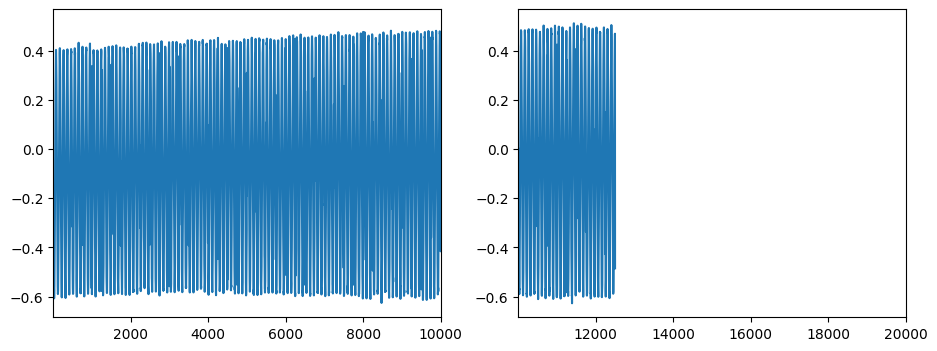

In [4]:
#limits to GRAPH (um motor movement)
left_lim = 5.
right_lim = 20000.

#calculate the indices to use in fit
dt = displacements[1] - displacements[0]
left_index = 5
right_index = 5000

#graph sections of the result at the edges
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(11,4))
ax[0].plot(displacements[left_index:right_index],vis_vals[0][left_index:right_index])
ax[0].set_xlim(left_lim,left_lim+0.5*(right_lim-left_lim))
ax[1].plot(displacements[left_index:right_index],vis_vals[0][left_index:right_index])
ax[1].set_xlim(right_lim-0.5*(right_lim-left_lim),right_lim)

#Use the cut-down histograms and x-values for the phase determination
limited_vis_vals = []
limited_unc_vals = []
for varr, uarr in zip(vis_vals, vis_uncs):
    limited_vis_vals.append(varr[left_index:right_index])
    limited_unc_vals.append(uarr[left_index:right_index])
limited_centers = displacements[left_index:right_index]

print(f"Left index is {left_index} and right index is {right_index}. The limited histograms have {len(limited_vis_vals[0])} indices.")
print(f"This means the limited array subtends {limited_centers[-1]-2*limited_centers[0] + limited_centers[1]} um.")

#### Define models 

-Don't interpret a repeated parameter labels (between different models) to always mean the same thing.

-MUST name the (fundamental) angular frequency "angfreq" and the phase "phase"!

For each model, I defined the model function, the initial guesses of the parameters, the lmfit parameters object with constraints, the lmfit model, and a string to show the model equation in graphics. 

In [5]:
#################FIRST MODEL: pure sine
#The fitting function
def pure_sinusoid_function(x, a, angfreq, phase, d):
    return a*np.sin(angfreq*x + phase) + d

#Initial guesses of the values of the parameters
def pure_sinusoid_guesses(hist_index):
    hist = limited_vis_vals[hist_index]
    d = np.mean(hist)
    a = np.max(hist) - d
    angfreq = 2.*np.pi*spot_df.iloc[hist_index]['vis_freq_max(inv um)']
    phase = 0.2255
    return (a, angfreq, phase, d)

#define the parameter object, including value guesses and limits
def pure_sinusoid_constrained_params(model, g, spot_index): #g is the guess function.
    g0 = g[0]
    g1 = g[1]
    g2 = g[2]
    g3 = g[3]
    fourfreq = spot_df.iloc[spot_index]['vis_freq_max(inv um)']
    params = model.make_params(a=dict(value=g0,min=0.01,max=1.1),
                      angfreq=dict(value=g1,min=0.98*2*np.pi*fourfreq,max=1.02*2*np.pi*fourfreq),
                      phase=dict(value=g2,min=-np.pi,max=2*np.pi),
                      d=dict(value=g3,min=-1.5,max=1.5))
    return params

pure_sinusoid_model = lmfit.Model(pure_sinusoid_function)

pure_sinusoid_fitfunc_str = "$A\sin{\omega x + \phi} + D$"
#####################


#################SECOND MODEL: sine * + linears
def sine_linears_function(x, a, angfreq, phase, d, e, f):
    return a*np.sin(angfreq*x + phase)*(1.0+d*x) + e*x + f
    
def sine_linears_guesses(hist_index):
    hist = limited_vis_vals[hist_index]
    f = np.mean(hist)
    a = np.max(hist) - f
    angfreq = 2.*np.pi*spot_df.iloc[hist_index]['vis_freq_max(inv um)']
    phase = 0.2255
    d = 0.0
    e = 0.0
    return (a, angfreq, phase, d, e, f)
    
def sine_linears_constrained_params(model, g, spot_index): 
    g0 = g[0]
    g1 = g[1]
    g2 = g[2]
    g3 = g[3]
    g4 = g[4]
    g5 = g[5]
    fourfreq = spot_df.iloc[spot_index]['vis_freq_max(inv um)']
    params = model.make_params(a=dict(value=g0,min=0.01,max=1.1),
                      angfreq=dict(value=g1,min=0.98*2*np.pi*fourfreq,max=1.02*2*np.pi*fourfreq),
                      phase=dict(value=g2,min=-np.pi,max=2*np.pi),
                      d=dict(value=g3,min=-1./12000.,max=1./12000.),
                      e=dict(value=g4,min=0.,max=1./12000.),
                      f=dict(value=g5,min=-0.5,max=0.5))
    return params
    
sine_linears_model = lmfit.Model(sine_linears_function)

sine_linears_fitfunc_str = r"$A\sin{(\omega x + \phi)}(1+Dx)+Ex+F$"
###################

#### Choose a model

In [6]:
#choose a model function
selected_function = sine_linears_function

#specify the guesses + constraints to match the chosen function
if selected_function == pure_sinusoid_function:
    guesses = pure_sinusoid_guesses
    model = pure_sinusoid_model
    constrained_params = pure_sinusoid_constrained_params
    fitfunc_str = pure_sinusoid_fitfunc_str
elif selected_function == sine_linears_function:
    guesses = sine_linears_guesses
    model = sine_linears_model
    constrained_params = sine_linears_constrained_params
    fitfunc_str = sine_linears_fitfunc_str

#### Create fits for all spots

Only least_sq seemed to produce an uncertainty in the result, but it (with our model, etc.) only got 2 sines right! differential_evolution can get 5 accurate with no parameter uncertainties. The reason I want uncertainties on parameters is because I need to know how far out I can trust our frequencies. This is the option I do, because I don't think 2 wavelengths will tell us very much. During SULI I tried some other models and bounds and this (5 good-looking fits) is the best I've done.

The phase-angfreq values produced by least_sq are in a screenshot on my (Trevor's) github.

In [7]:
#define a fit using lmfit, not scipy for an accurate covariance matrix

results = []
for i, (varr, uarr) in enumerate(zip(limited_vis_vals, limited_unc_vals)):  
    specific_guesses = guesses(i)
    params = constrained_params(model, specific_guesses, i)
    for pname, guess in zip(params.valuesdict().keys(), specific_guesses):
        params[pname].set(guess)
    weights = 1./uarr
    result = model.fit(varr,params,weights=weights,x=limited_centers,method='differential_evolution')
    #result = model.fit(varr,params,x=limited_centers,method='ampgo') #weightless fit
    results.append(result)

#why is it still saying there are ufloats with no st_dev?

C:\Users\tdavd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [8]:
results[0]

In [9]:
#%matplotlib widget

#### Graph the fits with the data

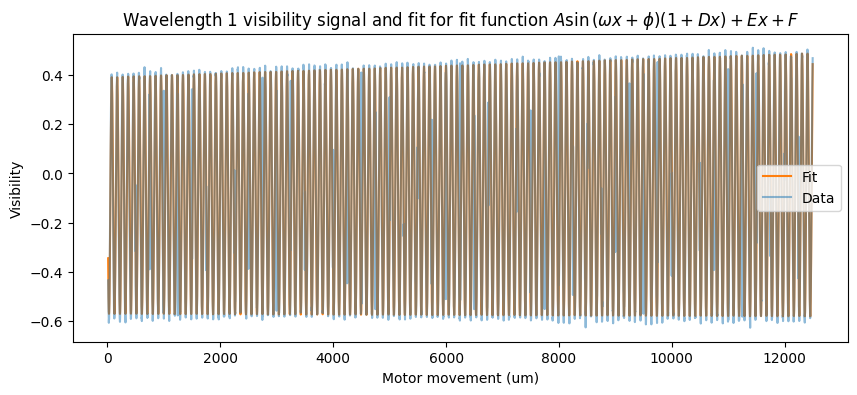

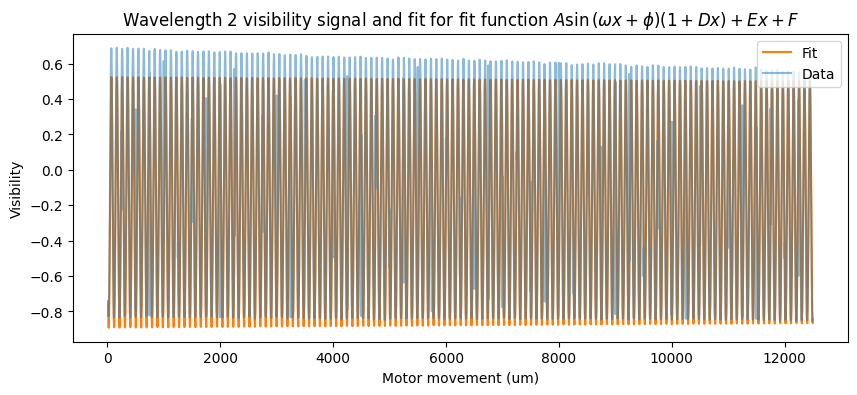

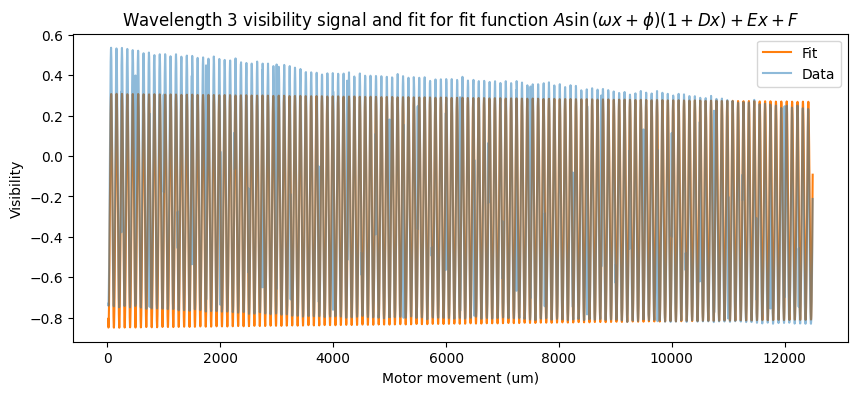

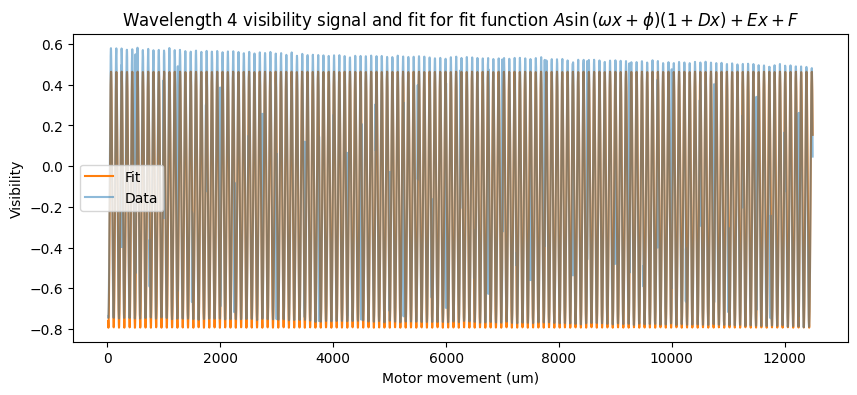

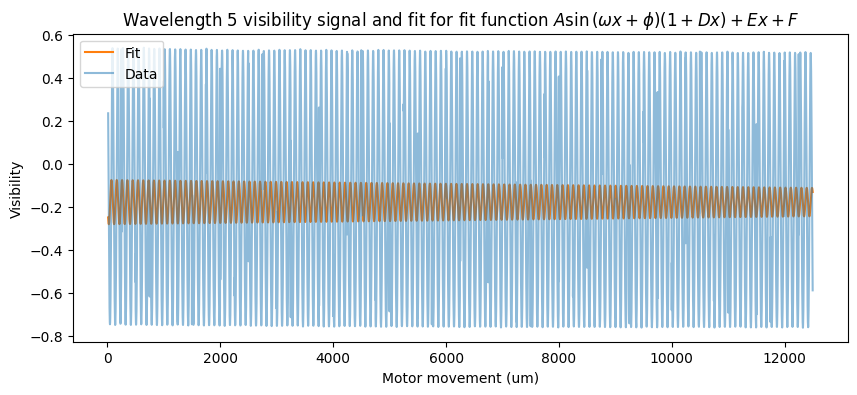

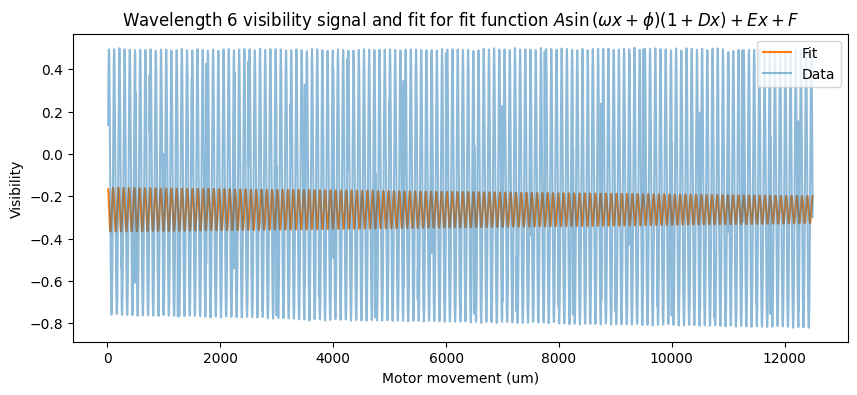

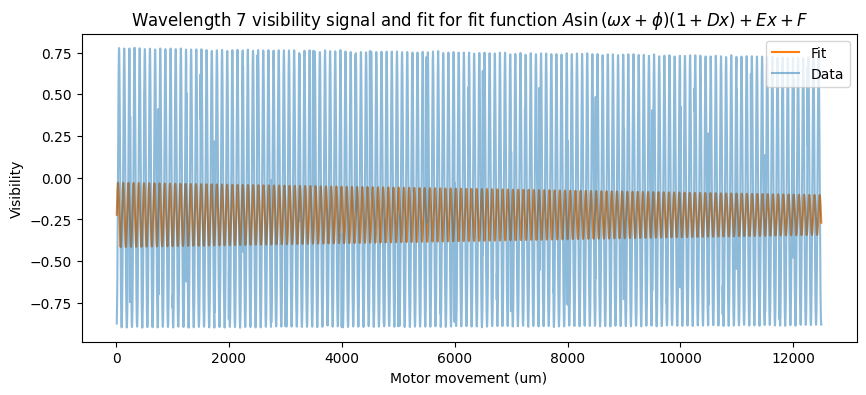

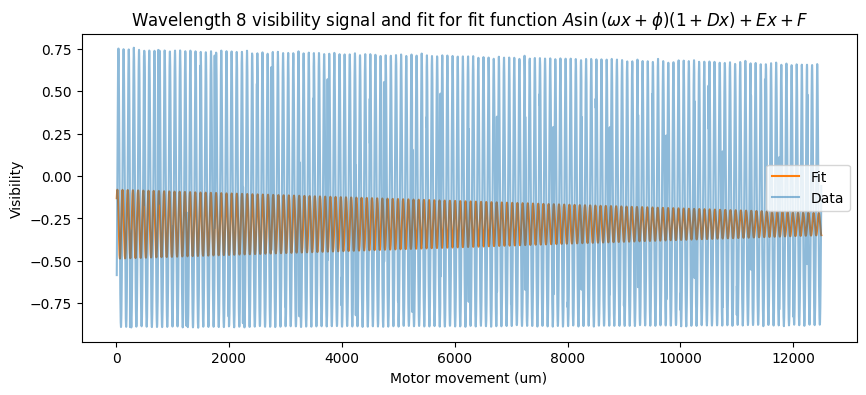

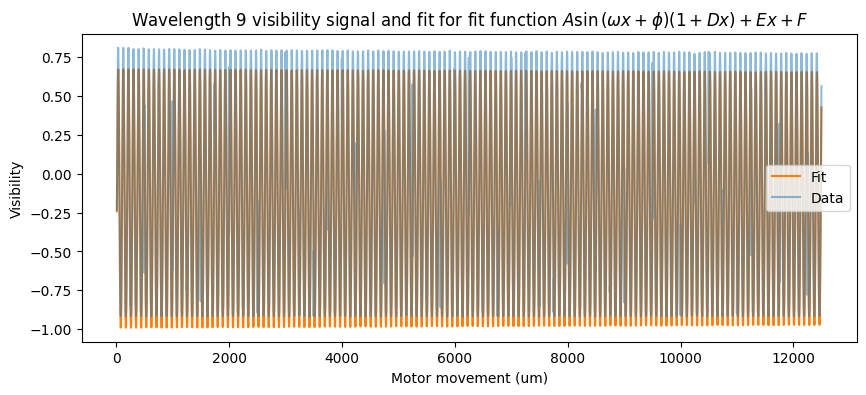

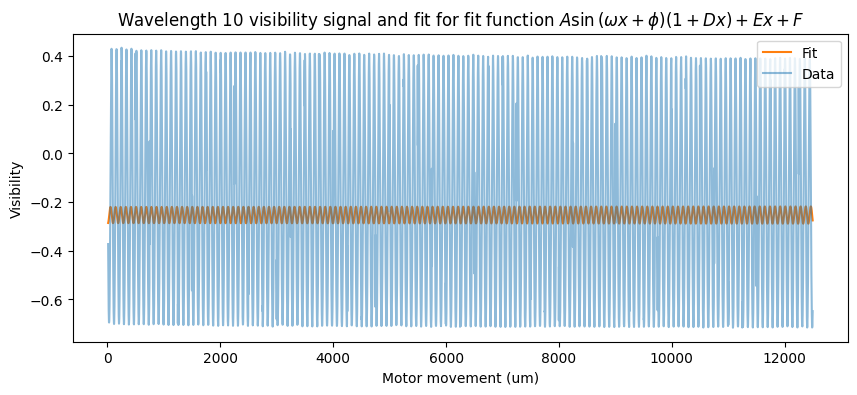

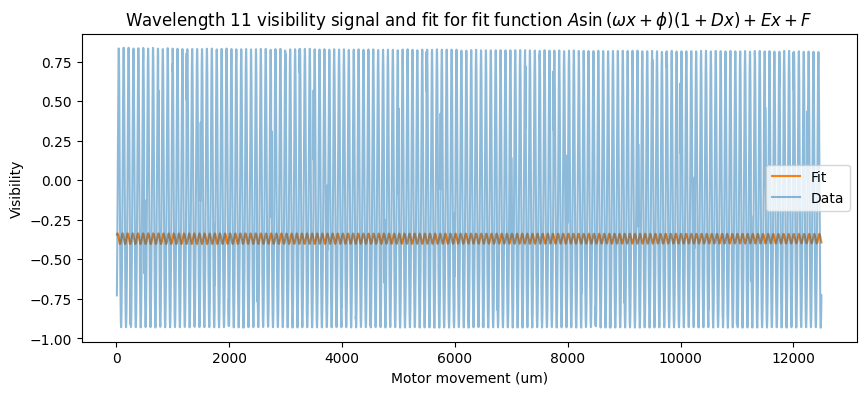

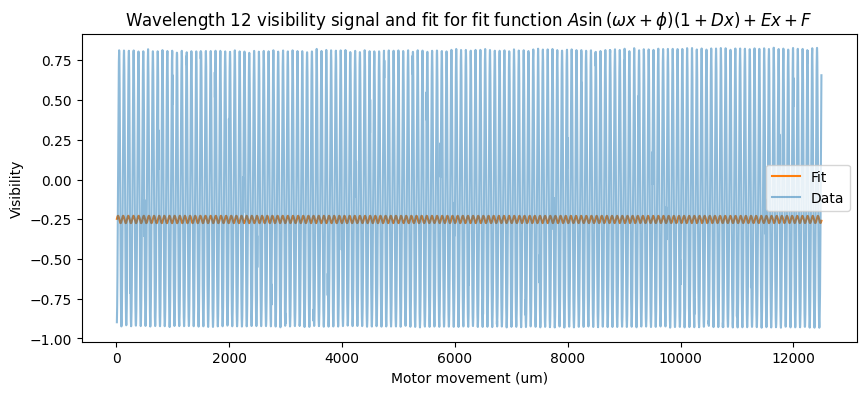

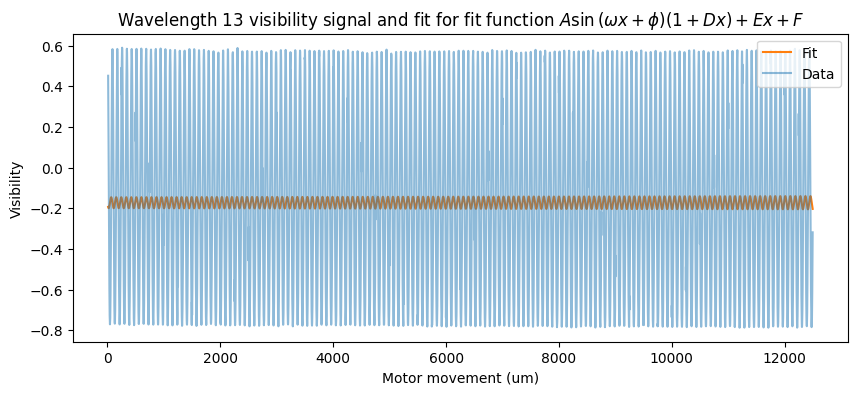

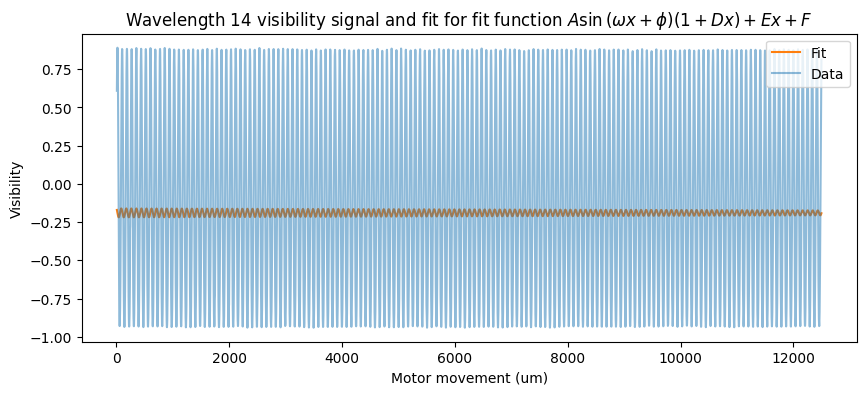

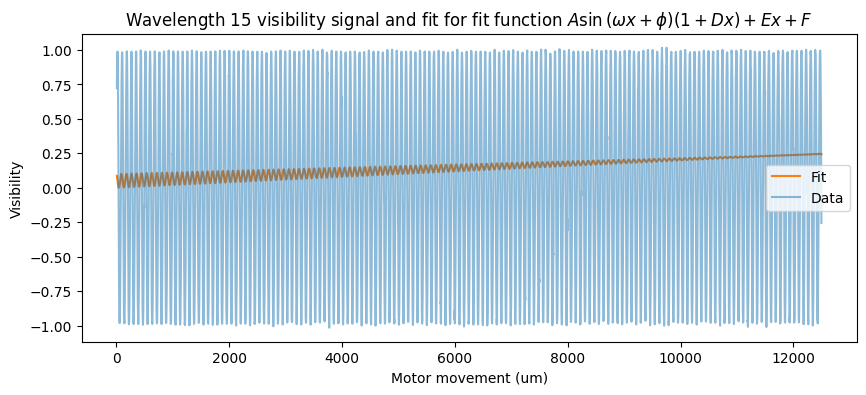

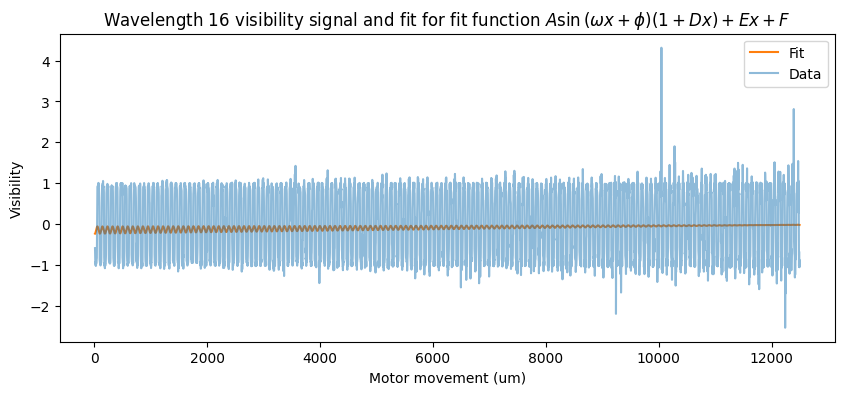

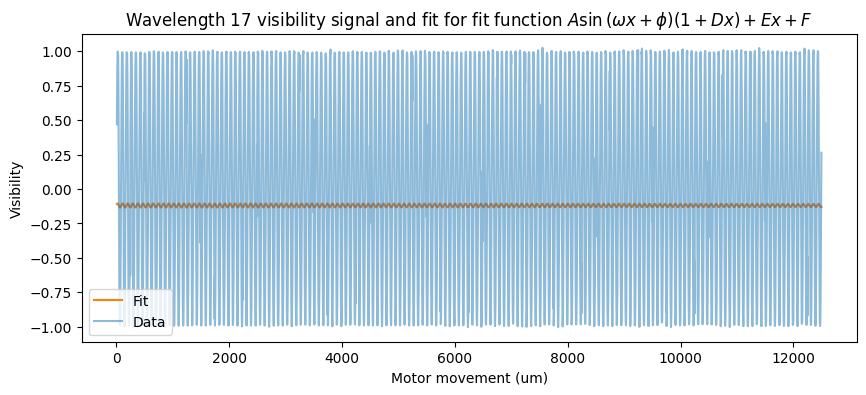

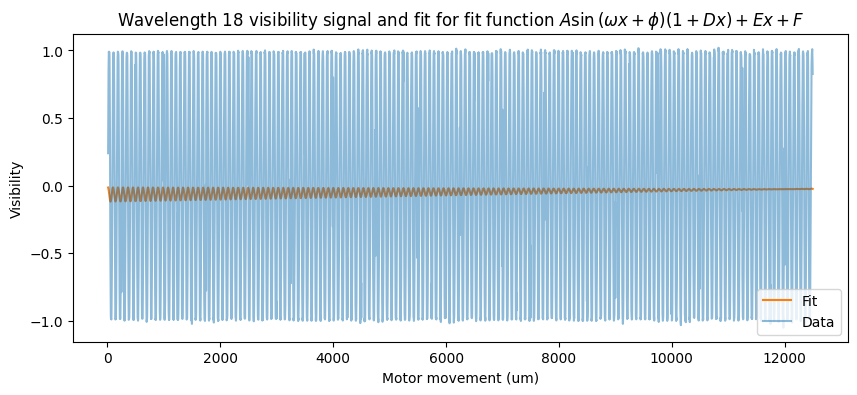

In [10]:
#initial and final indices to graph
p0 = 0
pf = -1

for j, spot in spot_df.iloc[::2].iterrows():
    i = j // 2
    varr = limited_vis_vals[i]
    uarr = limited_unc_vals[i]
    result = results[i]
    fig, ax = plt.subplots(figsize=(10,4))
    #ax.errorbar(limited_centers[p0:pf],varr[p0:pf],yerr=uarr[p0:pf],label='Data')
    fitted_func = model.eval(result.params,x=limited_centers)
    ax.plot(limited_centers[p0:pf],fitted_func[p0:pf],label='Fit',color='tab:orange')
    ax.plot(limited_centers[p0:pf],varr[p0:pf],label='Data',color='tab:blue',alpha=0.5)
    ax.set_title(f"Wavelength {i+1} visibility signal and fit for fit function " + fitfunc_str)
    ax.set_xlabel('Motor movement (um)')
    ax.set_ylabel('Visibility')
    ax.legend()

#### For non-least_sq methods, manually look at the good fits' edge fringes to see how precise they are

Also choose spot indices to be excluded/included from the path length difference search (count from 0, top-down from the graphs above) due to bad fit

In [11]:
#index the following by include_list. Count how much orange (fit) is AHEAD, in um motor movement.
#Assume angular frequency dominates the uncertainty

include_list = [0,1,2,3,8]
exclude_list = [100,4,5,6,7,9,10,11,12,13,14,15,16,17] #needs to have at least one element for the check not to crash

#The first and last times a maximum occurs in the good fits among the above graphs
first_maxima_locations_fit = np.array([76.9,70.5,66.6,65.1,37.0])
first_maxima_locations_data = np.array([74.1,68.4,64.1,62.2,34.9])
last_maxima_locations_fit = np.array([12404.3,12446.4,12418.0,12479.7,12416.0])
last_maxima_locations_data = np.array([12402.5,12445.6,12416.1,12478.5,12413.5])

dx_fit = last_maxima_locations_fit-first_maxima_locations_fit
dx_data = last_maxima_locations_data-first_maxima_locations_data

manual_freqs = []
for i in include_list:
    manual_freqs.append(results[i].params['angfreq'].value)
manual_freqs = np.array(manual_freqs)

n_periods_fit = np.rint(0.5*dx_fit*manual_freqs/np.pi)
n_periods_data = np.rint(0.5*dx_data*manual_freqs/np.pi)

#extra um that the fit subtends in n_periods_fit periods
dx_discrepancy = dx_fit - dx_data * (n_periods_fit/n_periods_data) #n_periods are the same here, but in case the data is changed and they're like 1 off

offset_per_fringe = (manual_freqs * dx_discrepancy) / (n_periods_fit * 2 * np.pi) #how many fringes the fit is off per fringe due to angular frequency error.

tolerance = 0.1 #how much of a fringe we're allowed to be off by. We will only look for path lengths within this range.

um_to_analyze = np.fabs((2*np.pi/manual_freqs) * tolerance / offset_per_fringe) #per side, that is.

um_to_analyze #how many micrometers we can analyze until we're tolerance*1 fringe offset.

array([119660.9237083 ,  91327.26063529, 197110.55748542,  68686.9582129 ,
       279640.94168431])

#### Print all fitted parameters from good-looking fits with uncertainties (which are only nonzero if you're using least_sq-- differential_evolution surely isn't THAT precise)

In [12]:
for i, spot in spot_df.iloc[::2].iterrows():
    if i//2 in include_list:
        print(f"Spot {i//2+1:2} (??? nm):", end=' ')
        result = results[i//2]
        for name in list(result.params):
            print(f"{name} = {result.params.create_uvars()[name].n:.9f}+/-{result.params.create_uvars()[name].s:.9f}", end=',   ')
        print()

Spot  1 (??? nm): a = 0.481238613+/-0.000000000,   angfreq = 0.064729992+/-0.000000000,   phase = 2.890976987+/-0.000000000,   d = 0.000008955+/-0.000000000,   e = 0.000003486+/-0.000000000,   f = -0.089935410+/-0.000000000,   
Spot  2 (??? nm): a = 0.708232500+/-0.000000000,   angfreq = 0.065494199+/-0.000000000,   phase = -3.053925681+/-0.000000000,   d = -0.000002853+/-0.000000000,   e = 0.000000000+/-0.000000000,   f = -0.183511959+/-0.000000000,   
Spot  3 (??? nm): a = 0.580270250+/-0.000000000,   angfreq = 0.065621198+/-0.000000000,   phase = 3.497542901+/-0.000000000,   d = -0.000005526+/-0.000000000,   e = 0.000000000+/-0.000000000,   f = -0.271022949+/-0.000000000,   
Spot  4 (??? nm): a = 0.628847607+/-0.000000000,   angfreq = 0.066804425+/-0.000000000,   phase = -2.730717236+/-0.000000000,   d = -0.000000033+/-0.000000000,   e = 0.000000000+/-0.000000000,   f = -0.164383451+/-0.000000000,   
Spot  9 (??? nm): a = 0.832240354+/-0.000000000,   angfreq = 0.069536012+/-0.000000

#### Store the final results in a dictionary to be used later

In [13]:
final_params = {}
for pname in results[0].params:
    plist = []
    for i, spot in spot_df.iloc[::2].iterrows():
        plist.append(results[i//2].params[pname].value)
    final_params[pname] = plist

#### Graph frequencies vs expected frequencies

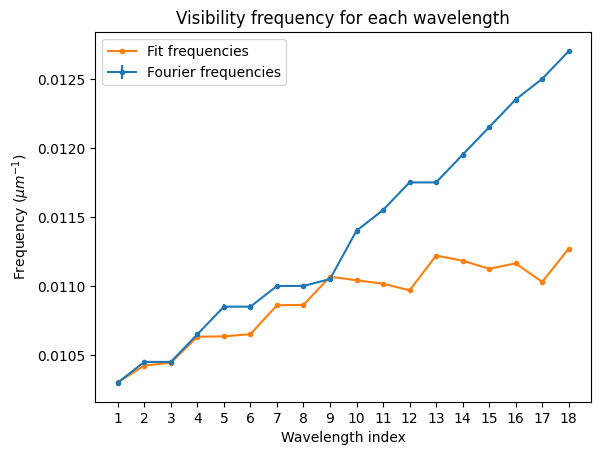

In [14]:
###### a temporary working version for the poster graph
fourier_freqs = np.array(spot_df['vis_freq_max(inv um)'])[::2]
fit_freqs = 0.5 * np.array(final_params['angfreq']) / np.pi
wl_inds = (np.arange(18)+1) 
###NOTICE: WAVELENGTHS ARE IN THE OPPOSITE ORDER FROM LAST YEAR'S CODE!!!!

####################################################################################### below this, I haven't accounted for that opp order

wl_inds_reduced = [1, 4, 9, 10, 11, 16, 18]
base_wls = np.array([696.54300, 714.70410,  750.38680,763.51054,772.37600,826.45215,852.14411])*1.0003 #since they're given in AIR on NIST!
def sellmeier_bk7(wavelength): # Measured in nm
    return np.sqrt(1 + 1.03961212*wavelength**2/(wavelength**2-6.00069867e3) + 0.231792344*wavelength**2/(wavelength**2-2.00179144e4) + 1.01046945*wavelength**2/(wavelength**2-1.03560653e8))
theory_freqs = ((sellmeier_bk7(base_wls)) * np.tan(np.pi/180.) / base_wls) * 1000

fourier_unc = 0.5/(30000.)
fourier_uncs = np.ones(18)*fourier_unc

fig, ax = plt.subplots()
ax.errorbar(wl_inds,fourier_freqs,yerr=fourier_uncs,marker='.',label='Fourier frequencies')
ax.plot(wl_inds,fit_freqs,marker='.',label='Fit frequencies')
#ax.plot(wl_inds_reduced,theory_freqs,marker='.',label='Theoretical frequencies')
ax.set_xlabel('Wavelength index')
ax.set_ylabel('Frequency ($\mu m^{-1}$)')
ax.set_xticks(wl_inds)
ax.set_title('Visibility frequency for each wavelength')
ax.legend()
######

In [15]:
#these two blocks useless until we know the actual expected frequencies

#expected_freqs = np.array(spot_df['expected_freq_max(inv um)'])[::2]
#
#fourier_freqs = np.array(spot_df['vis_freq_max(inv um)'])[::2]
##uncertainty from frequency resolution
#df = 1./(displacements[-1]+displacements[1]-2*displacements[0])
#n_spots = len(spot_df)//2
#fourier_freqs_unc = 0.5*df*np.ones(n_spots) #half the finest resolution
#
#fit_freqs = 0.5 * np.array(final_params['angfreq']) / np.pi
##get all original values and uncertainties as a list of dictionaries of ufloats
#param_ufloats = []
#for i, result in enumerate(results):
#    param_ufloats.append(result.params.create_uvars())
##uncertainty from the fit 
#fit_freqs_unc = []
#for param_dict in param_ufloats:
#    unc = 0.5 * param_dict['angfreq'].s / np.pi #uncertainty in angfreq
#    fit_freqs_unc.append(unc)
#fit_freqs_unc = np.array(fit_freqs_unc)
#erscale = 10 #the uncertainty is small, but we should show meaningful errorbars
#
#fig, ax = plt.subplots()
#ax.plot(expected_freqs,expected_freqs,label='Theory',ls='-',color='red')
#ax.errorbar(expected_freqs,fourier_freqs,yerr=fourier_freqs_unc,label='Fourier Transform',ls='solid',color='blue')
#ax.errorbar(expected_freqs,fit_freqs,yerr=erscale*fit_freqs_unc,
#            label=f'Fit; uncertainty scaled by {erscale}',ls='solid',color='green')
#ax.set_title("Modulation frequencies for all spots")
#ax.set_xlabel('Expected frequency ($\mathrm{min^{-1}}$)')
#ax.set_ylabel('Frequency ($\mathrm{min^{-1}}$)')
##ax.set_ylim(0,2.9)
#ax.legend()

In [16]:
#this only works if expected_freqs has no uncertainty
#
#fig, ax = plt.subplots()
#ax.plot(expected_freqs,expected_freqs/expected_freqs,label='Theory',ls='-',color='red')
#
#ax.errorbar(expected_freqs,fourier_freqs/expected_freqs,yerr=fourier_freqs_unc/expected_freqs,label='Fourier Transform',ls='solid',color='blue')
#
#ax.errorbar(expected_freqs,fit_freqs/expected_freqs,yerr=erscale*fit_freqs_unc/expected_freqs,
#            label=f'Fit; uncertainty scaled by {erscale}',ls='solid',color='green')
#
#ax.set_title("Modulation frequencies per expected frequency for all spots")
#ax.set_xlabel('Expected frequency ($\mathrm{min^{-1}}$)')
#ax.set_ylabel('Frequency / Expected Frequency')
#ax.legend()

#### Walk back all fringes by a given distance *in both directions* and count close maxima in bins

We have to exclude the obviously "bad" fits. At this time those are of the last 3 wavelengths.

In [17]:
#distances (except for nm wavelengths in sellmeier eqn) in microns, time in seconds

#wavelengths = np.array([wl for wl in spot_df['wavelength(nm)']]) #nm
#output_numbers = np.array([wl for wl in spot_df['wavelength(nm)']])

#make arrays of points representing maxima in microns
@njit()
def find_maxima_locations(angfreqs, phases, exclude_list, max_path_view = min(um_to_analyze)):
    maxima_locations = []
    for i, (angfreq, phase) in enumerate(zip(angfreqs, phases)):
        if i in exclude_list: # SKIP BAD FITS
            continue
        path_view = 0.0
        inv_angfreq = 1./angfreq
        specific_maxima_locations = [(0.5*np.pi-phase)*inv_angfreq] #motor travel distance, um
        n = 1
        while path_view < max_path_view: #to make this monotonic
            specific_maxima_locations.append((np.pi*(0.5+2*n)-phase)*inv_angfreq)
            specific_maxima_locations.append((np.pi*(0.5-2*n)-phase)*inv_angfreq)
            path_view += 2.*np.pi*inv_angfreq
            n += 1
        maxima_locations.append(np.sort(np.array(specific_maxima_locations)))
    return maxima_locations

@njit() #for each spot, for each edge, loop over a subset of maxima loc's and see whether one's in there.
def bin_maxima(maxima_locations, path_view = 80000.0, width=0.053, delta=0.02):
    max_bin_edges = np.arange(-path_view, path_view, delta) #LEFT edges of the bins
    max_hist = np.zeros(len(max_bin_edges)) #histogram with bin values.
    for i, specific_maxima_locations in enumerate(maxima_locations): #specific, as in, at a specific wavelength
        for j, edge in enumerate(max_bin_edges):
            for max_loc in specific_maxima_locations:
                if edge < max_loc < (edge + width): #stop if we reach it
                    max_hist[j] += 1
                    break
                elif max_loc > (edge + width): #stop if we pass it
                    break
    bin_centers = max_bin_edges + 0.5 * width
    return max_hist, bin_centers

#### Calculate and graph the histogram of maxima locations. 

Ideally, the "correct" absolute path length will have the wavelength the closest together and in wavelength order. This might take a minute to run.

In [18]:
width = 10 #um of movement

angfreqs = final_params['angfreq']
#angfreqs = fourier_freqs * np.pi * 2.
#angfreqs = expected_freqs * np.pi * 2.

maxima_locations = find_maxima_locations(angfreqs, final_params['phase'], exclude_list)
max_hist, bin_centers = bin_maxima(maxima_locations, width=width)

In [92]:
#%matplotlib widget

An instance of the most maxima occurs at index 3969801, which is x = -598.9799999999959, with a total of 5.0 maxima.


(0.0, 5.5)

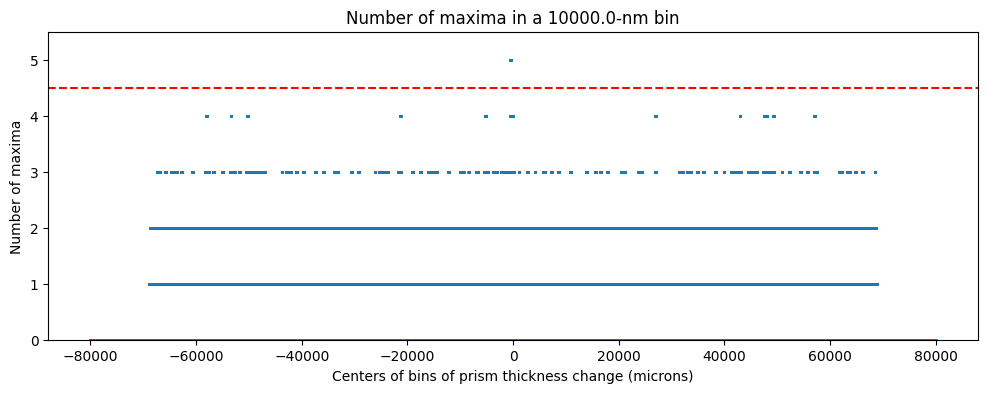

In [19]:
histmax_index = np.argmax(max_hist)
histmax_position = bin_centers[np.argmax(max_hist)]
histmax = np.max(max_hist)

print(f"An instance of the most maxima occurs at index {histmax_index}, which is x = {histmax_position}, with a total of {histmax} maxima.")

threshold = len(maxima_locations)-0.5 #if you see blue above the red line, all maxima occur within width somewhere.

fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(bin_centers, max_hist, s=1)
ax.axhline(threshold,color='red',ls='--')
ax.set_xlabel("Centers of bins of prism thickness change (microns)")
ax.set_ylabel("Number of maxima")
ax.set_title(f"Number of maxima in a {width*1000.}-nm bin")
ax.set_ylim(0,threshold+1)
#ax.set_xlim(-10, 10)

#### Graph the fit functions together and manually look closer at promising locations.

Note that by default, matplotlib places plots on top of each other in the order they are added to a figure.

Text(0, 0.5, 'Normalized shifted fit amplitude')

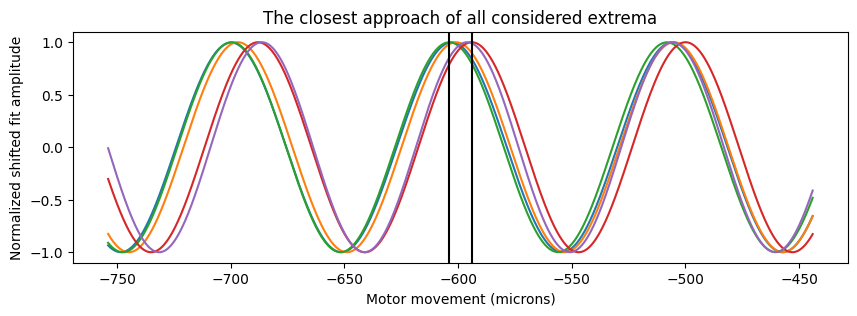

In [20]:
line_left = histmax_position - 0.5*width
line_right = histmax_position + 0.5*width
plot_bound_left = line_left - 150
plot_bound_right = line_right + 150

fig, ax = plt.subplots(figsize=(10,3))
x = np.linspace(plot_bound_left,plot_bound_right, 20000)

#FIXME: MAKE ANGFREQ IN INVERSE MICRONS
for i, spot in spot_df.iloc[::2].iterrows():
    if i//2 in exclude_list:
        continue
    plot_params = lmfit.create_params()
    for key in final_params.keys():
        plot_params.add(key,value=final_params[key][i//2])
#    plot_params['angfreq'].set(plot_params['angfreq'])
    model_plot = model.eval(params=plot_params,x=x)
    ax.plot(x, 2.*(model_plot - 0.5*(np.max(model_plot)+np.min(model_plot)))/(np.max(model_plot)-np.min(model_plot)))

#manually bound maxima
if plot_bound_left < line_left:
    ax.axvline(line_left,color='k')
if plot_bound_right > line_right:
    ax.axvline(line_right,color='k')

ax.set_title("The closest approach of all considered extrema")
ax.set_xlabel("Motor movement (microns)")
ax.set_ylabel("Normalized shifted fit amplitude")

#### Plot the order of fringes at the closest approach

If this difference is purely due to slight smearing due to passing through a small length of air or BK7, for example, one expects a monotonic function (different spots with the same wavelength should be at the same location).

We have located 5 maxima in the selected region.


Text(0, 0.5, 'Maximum location (microns)')

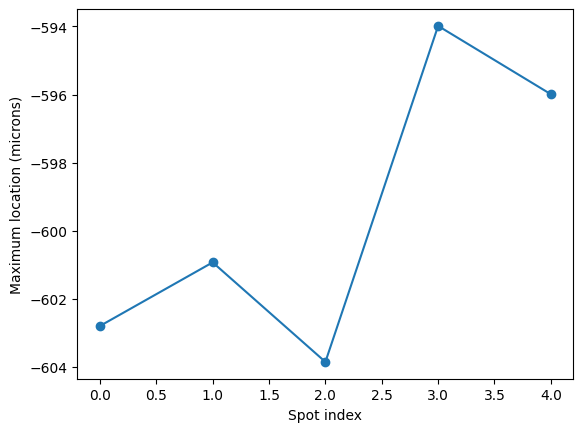

In [21]:
max_order_list = []
for i, specific_max_locs in enumerate(maxima_locations):
    for max_loc in specific_max_locs:
        if line_left < max_loc < line_right:
            max_order_list.append([i,max_loc])
max_order_array = np.array(max_order_list)
            
print(f"We have located {len(max_order_list)} maxima in the selected region.")

fig, ax = plt.subplots()
ax.plot(max_order_array[:,0],max_order_array[:,1],marker='o')
ax.set_xlabel('Spot index')
ax.set_ylabel('Maximum location (microns)')

### Discussion

No confirmation yet.

That sinusoid proof Aaron was working on isn't done as far as I know (as of 8/24/25). To assure ourselves that this closeness (knowing this closeness is "real" only if the uncertainty in angfreq and phase is small enough) isn't a fluke, I think it's necessary.

I think it's kind of ridiculous that I can't seem to fit to most of these functions with this general a model. Look how siney (perhaps with the help of widget) they look! 